**Name: Krish Murjani | N Number: N10121101 | NetID: km6520**

### **AI CS-GY-6613 Assignment 1B**

# **Logistic Regression**

# **Task 1: Data Preprocessing** 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import RandomOverSampler

In [2]:
total_records = 40428967
sample_count = 200000
skip_indices = sorted(random.sample(range(1, total_records), total_records - sample_count))

train_data = pd.read_csv("/kaggle/input/assignment1b-2/train.csv", skiprows=skip_indices)
train_data.head(2)

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,10006958186789044052,1,14102100,1005,0,85f751fd,c4e18dd6,50e219e0,0acbeaa3,45a51db4,...,1,0,18993,320,50,2161,0,35,100034,157
1,10010485868773711631,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15701,320,50,1722,0,35,100084,79


In [3]:
import numpy as np
# Assuming 'train_data' is a pandas DataFrame
for feature in ['C15', 'C16', 'C19', 'C21']:
    upper_percentile = train_data[feature].quantile(0.98)
    if upper_percentile < 0.5 * train_data[feature].max():
        train_data[feature] = np.where(train_data[feature] >= upper_percentile, upper_percentile, train_data[feature])

## optimizing classification models by defining numerical & categorical variables



In [4]:
num_features = []
cat_features = []

for column in (train_data.columns):
    if train_data[column].dtype == "object":
        cat_features.append(column)
    else:
        num_features.append(column)
print("Numerical columns = ", num_features)
print("\nCategorical columns = ", cat_features)

Numerical columns =  ['id', 'click', 'hour', 'C1', 'banner_pos', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21']

Categorical columns =  ['site_id', 'site_domain', 'site_category', 'app_id', 'app_domain', 'app_category', 'device_id', 'device_ip', 'device_model']


click
0    0.829035
1    0.170965
Name: proportion, dtype: float64




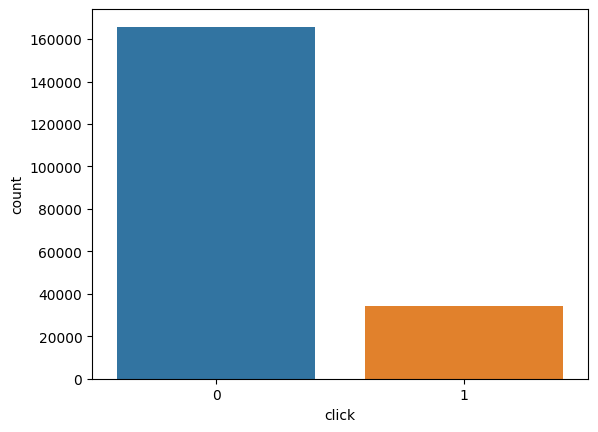

In [5]:
print(train_data.click.value_counts(normalize=True))
print("\n")
plt.figure()
sns.countplot(x='click', data=train_data)
plt.show()

### data is highly imbalanced: 83% are 0s, 17% are 1s. 
### predicting all 0s gives 83% accuracy. 
### balance the data before training the model.


In [6]:
train_data.drop(['hour', 'C20'], axis=1, inplace=True)
train_data.columns

Index(['id', 'click', 'C1', 'banner_pos', 'site_id', 'site_domain',
       'site_category', 'app_id', 'app_domain', 'app_category', 'device_id',
       'device_ip', 'device_model', 'device_type', 'device_conn_type', 'C14',
       'C15', 'C16', 'C17', 'C18', 'C19', 'C21'],
      dtype='object')

In [7]:
train_data.drop(['id'], axis=1, inplace=True)
train_data.rename(columns={'click': 'target'}, inplace=True)

train_data.columns

Index(['target', 'C1', 'banner_pos', 'site_id', 'site_domain', 'site_category',
       'app_id', 'app_domain', 'app_category', 'device_id', 'device_ip',
       'device_model', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16',
       'C17', 'C18', 'C19', 'C21'],
      dtype='object')

In [8]:
sampled_data = train_data.sample(frac=0.1, random_state=42)
X_sample = sampled_data.drop(['target'], axis=1)
y_sample = sampled_data['target']

target
0    0.829035
1    0.170965
Name: proportion, dtype: float64




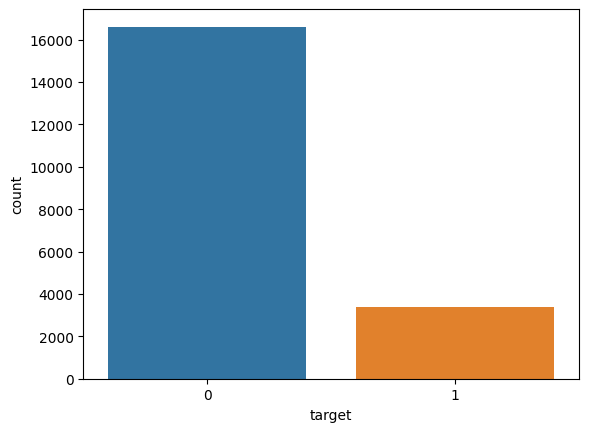

In [9]:
print(train_data.target.value_counts(normalize=True))
print("\n")
plt.figure()
sns.countplot(x=y_sample)
plt.show()

In [10]:
import category_encoders as ce
encoder = ce.TargetEncoder()
X_sample_encoded = encoder.fit_transform(X_sample, y_sample)
X_sample_encoded.head(2)

,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C21
119737,1002,0,0.321636,0.308627,0.119141,0.205249,0.200564,0.205539,0.277816,0.277816,0.322835,0,0,21789,320.0,50.0,2512,2,291,52
72272,1005,0,0.204132,0.204132,0.209069,0.205249,0.200564,0.205539,0.176556,0.217850,0.134900,1,0,15705,320.0,50.0,1722,0,35,79


### balancing w/ random oversampling


Original dataset shape: Counter({0: 16604, 1: 3396})
Resampled dataset shape: Counter({1: 16604, 0: 16604})


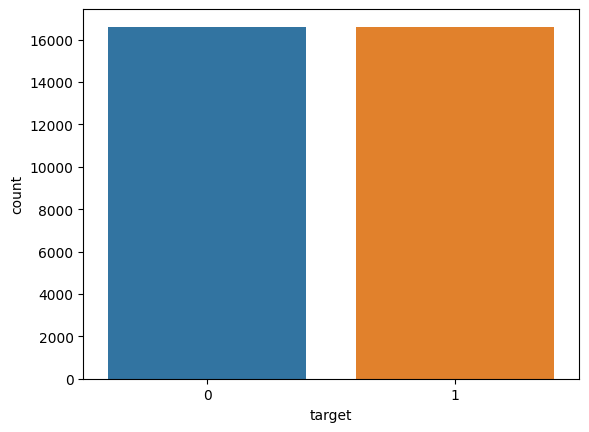

In [11]:
oversample = RandomOverSampler()
X_balanced, y_balanced = oversample.fit_resample(X_sample_encoded, y_sample)

from collections import Counter
print('Original dataset shape: {}'.format(Counter(y_sample)))
print('Resampled dataset shape: {}'.format(Counter(y_balanced)))
sns.countplot(x=y_balanced)
plt.show()

In [12]:
X_balanced.head(2)

,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C21
0,1002,0,0.321636,0.308627,0.119141,0.205249,0.200564,0.205539,0.277816,0.277816,0.322835,0,0,21789,320.0,50.0,2512,2,291,52
1,1005,0,0.204132,0.204132,0.209069,0.205249,0.200564,0.205539,0.176556,0.217850,0.134900,1,0,15705,320.0,50.0,1722,0,35,79


In [13]:
X_train_set, X_test_set, y_train_set, y_test_set = train_test_split(X_balanced, y_balanced, stratify=y_balanced, test_size=0.25, random_state=42)

In [14]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_set[X_train_set.columns] = scaler.fit_transform(X_train_set[X_train_set.columns])
X_train_set.head()

,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C21
14902,0.363636,0.142857,0.433250,0.378381,0.613817,0.673560,0.707714,0.653555,0.203161,0.325893,0.394013,0.2,0.0,0.734049,1.0,0.130435,0.704236,0.666667,0.003322,0.125984
14231,0.363636,0.000000,0.155010,0.154430,0.386916,0.124045,0.269697,0.152766,0.203161,0.325893,0.176767,0.2,0.4,0.962098,1.0,0.130435,0.965582,0.000000,0.000554,0.866142
8772,0.363636,0.000000,0.155010,0.154430,0.386916,0.924358,0.422361,0.725559,0.203161,0.898025,0.666741,0.2,0.0,0.834657,1.0,0.130435,0.828669,0.666667,0.003322,0.086614
28731,0.363636,0.000000,0.219058,0.186925,0.613817,0.673560,0.707714,0.653555,0.203161,0.898025,0.357135,0.2,0.0,0.819615,1.0,0.130435,0.799924,0.000000,0.357697,0.185039
9523,0.363636,0.000000,0.155010,0.154430,0.386916,0.487344,0.506320,0.049451,0.075918,0.325893,0.388272,0.2,0.0,0.856038,1.0,0.130435,0.855522,1.000000,0.003322,0.086614


In [15]:
X_train_tensor = torch.tensor(X_train_set.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_set.values, dtype=torch.float32).view(-1, 1)  # Column vector for y


# **Task 2: Logistic Regression** 

In [16]:
import torch.nn as nn

class LogReg(nn.Module):
    def __init__(self, input_dim):
        super(LogReg, self).__init__()
        self.linear_layer = nn.Linear(input_dim, 1)
    
    def forward(self, x):
        return torch.sigmoid(self.linear_layer(x))

In [17]:
import torch.optim as optim

# Initializing the model
input_size = X_train_tensor.shape[1]
log_model = LogReg(input_size)

# Loss function and optimizer
loss_function = nn.BCELoss()
optimizer = optim.SGD(log_model.parameters(), lr=0.01)

In [18]:
num_epochs = 10000

# Training loop
for epoch in range(num_epochs):
    # Forward pass
    predictions = log_model(X_train_tensor)
    loss = loss_function(predictions, y_train_tensor)
    
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [100/10000], Loss: 0.6736
Epoch [200/10000], Loss: 0.6555
Epoch [300/10000], Loss: 0.6392
Epoch [400/10000], Loss: 0.6238
Epoch [500/10000], Loss: 0.6091
Epoch [600/10000], Loss: 0.5952
Epoch [700/10000], Loss: 0.5819
Epoch [800/10000], Loss: 0.5693
Epoch [900/10000], Loss: 0.5572
Epoch [1000/10000], Loss: 0.5457
Epoch [1100/10000], Loss: 0.5348
Epoch [1200/10000], Loss: 0.5243
Epoch [1300/10000], Loss: 0.5142
Epoch [1400/10000], Loss: 0.5047
Epoch [1500/10000], Loss: 0.4955
Epoch [1600/10000], Loss: 0.4867
Epoch [1700/10000], Loss: 0.4782
Epoch [1800/10000], Loss: 0.4701
Epoch [1900/10000], Loss: 0.4623
Epoch [2000/10000], Loss: 0.4548
Epoch [2100/10000], Loss: 0.4476
Epoch [2200/10000], Loss: 0.4407
Epoch [2300/10000], Loss: 0.4340
Epoch [2400/10000], Loss: 0.4276
Epoch [2500/10000], Loss: 0.4214
Epoch [2600/10000], Loss: 0.4154
Epoch [2700/10000], Loss: 0.4096
Epoch [2800/10000], Loss: 0.4040
Epoch [2900/10000], Loss: 0.3986
Epoch [3000/10000], Loss: 0.3934
Epoch [3100/10000],

In [19]:
with torch.no_grad():
    log_model.eval()  # Evaluation mode
    predictions_train = log_model(X_train_tensor)
    train_predicted = (predictions_train > 0.5).float()
    train_accuracy = (train_predicted == y_train_tensor).float().mean()
    print(f'Training Accuracy: {train_accuracy.item():.4f}')


Training Accuracy: 0.9592


In [20]:
X_test_tensor = torch.tensor(X_test_set.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_set.values, dtype=torch.float32).view(-1, 1)

In [21]:
# After training the model
with torch.no_grad():
    log_model.eval()
    predictions_test = log_model(X_test_tensor)
    test_predicted = (predictions_test > 0.5).float()
    test_accuracy = (test_predicted == y_test_tensor).float().mean()
    print(f'Test Accuracy: {test_accuracy.item():.4f}')

Test Accuracy: 0.5000


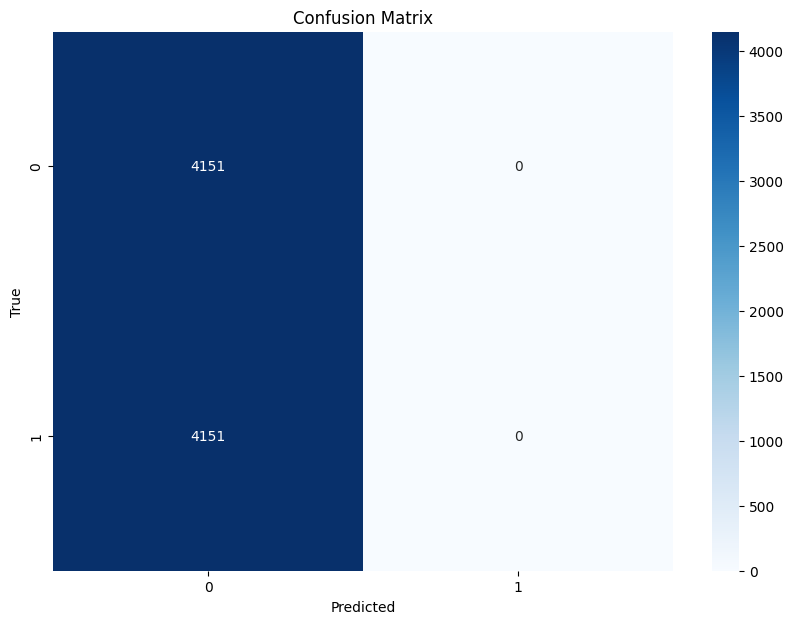

In [22]:
with torch.no_grad():
    log_model.eval()
    predictions_test = log_model(X_test_tensor)
    _, predicted_labels = torch.max(predictions_test, 1)
 # Get the class with the highest probability

y_pred_labels = predicted_labels.numpy().astype(int)
y_true_labels = y_test_tensor.numpy().astype(int)

# Confusion matrix setup
class_count = len(np.unique(y_true_labels))
conf_matrix = np.zeros((class_count, class_count), dtype=int)

for true_val, pred_val in zip(y_true_labels, y_pred_labels):
    conf_matrix[true_val, pred_val] += 1

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### creating a precision-recall chart

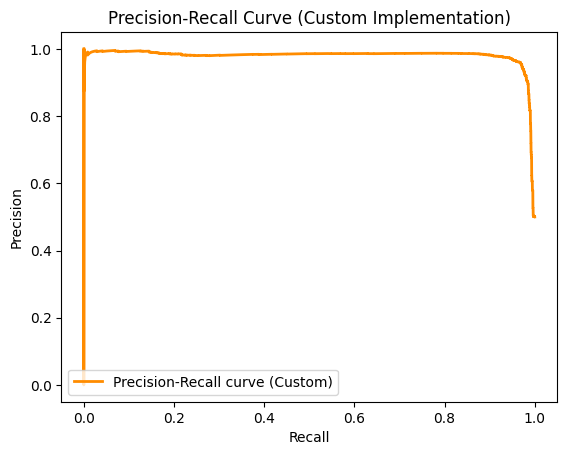

In [23]:
def precision_recall_custom(y_true_vals, y_score_vals):
    sorted_indices = np.argsort(-y_score_vals)
    y_true_sorted = y_true_vals[sorted_indices]
    y_scores_sorted = y_score_vals[sorted_indices]

    tp_count = 0 
    fp_count = 0  
    fn_count = sum(y_true_vals)
    
    precision_list = []
    recall_list = []
    prev_score_val = -1
    
    for idx in range(len(y_scores_sorted)):
        if y_scores_sorted[idx] != prev_score_val:
            prev_score_val = y_scores_sorted[idx]
            precision = tp_count / (tp_count + fp_count) if (tp_count + fp_count) > 0 else 0
            recall = tp_count / (tp_count + fn_count) if (tp_count + fn_count) > 0 else 0
            precision_list.append(precision)
            recall_list.append(recall)
        if y_true_sorted[idx] == 1:
            tp_count += 1
            fn_count -= 1
        else:
            fp_count += 1

    precision_list = [1] + precision_list
    recall_list = [0] + recall_list
    
    return np.array(precision_list), np.array(recall_list)

with torch.no_grad():
    log_model.eval()
    train_scores = log_model(X_train_tensor).numpy().flatten()
    y_train_vals = y_train_tensor.numpy().flatten()

prec_vals, rec_vals = precision_recall_custom(y_train_vals, train_scores)

# plotting
plt.figure()
plt.plot(rec_vals, prec_vals, color='darkorange', lw=2, label='Precision-Recall curve (Custom)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Custom Implementation)')
plt.legend(loc="lower left")
plt.show()